In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 2.2 $\quad$ Análisis del efecto de la diversificación en el riesgo de una cartera

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm import tqdm


plt.style.use('ggplot')


## 1. Efecto de la diversificación en el riesgo de una cartera

Hemos visto que la varianza de una cartera de dos activos viene definida por:

$$\sigma^2_p= \underset{\text{Activo 1}} {\underbrace{w_1^2\sigma^2_1}}+\underset{\text{Activo 2}} {\underbrace{w_2^2\sigma^2_2}}+ \underset{\text{Relación entre activos}} {\underbrace{2w_1w_2 \sigma_{12}}}$$
       


Podemos generalizar para una cartera con $n$ activos:

$$\sigma^2_p = \underset{\text{Riesgo Activos}} {\underbrace{\sum_{i=1}^n w_i^2 \sigma_i^2}} + \underset{\text{Relación entre activos}} {\underbrace{ \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}}} \quad \forall i \neq j$$




Si hacemos una cartera en la que invertimos la misma cantidad en cada activo $\Rightarrow w_i = \dfrac{1}{n}$, la varianza de la cartera se puede escribir como:

$$\sigma_p^2= \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i^2 + \dfrac{1}{n^2}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} \quad \forall i \neq j$$

Llamando:

* Varianza media de los activos 

$$\bar{V} = \dfrac{1}{n}\sum_{i=1}^{n} \sigma _i^2 \quad \Rightarrow \quad \sum_{i=1}^{n} \sigma _i^2 = n \bar{V}$$

* Covarianza media entre activos 

$$\bar{\sigma_{ij}} = \dfrac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} \quad \Rightarrow \quad  \sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} = n(n-1)\bar{\sigma_{ij}}$$

Sustituyendo en la ecuación de la varianza de una cartera equiponderada:

$$\sigma_p^2= \dfrac{1}{n^2}n \bar{V} + \dfrac{1}{n^2}n(n-1)\bar{\sigma_{ij}} = \dfrac{1}{n}\bar{V} + \left( 1 - \frac{1}{n}\right) \bar{\sigma_{ij}}$$

Si el número de activos $n$ tiende a infinito:

$$\lim_{n \to \infty} \sigma_p^2 =  \bar{\sigma_{ij}} $$

**Nos queda el riesgo sistémico o de mercado que no se puede eliminar con la diversificación**.

El riesgo sistémico es el riesgo que afecta a todos los activos de una cartera.

<center>
    <img src="../imgs/tipos_de_riesgos.PNG"  alt="drawing" width="400">
</center>

## 2. Datos reales con S&P500

## EJERCICIO DE ANÁLISIS DEL EFECTO DE LA DIVERSIFICACIÓN:

**Objetivo:** El objetivo de este ejercicio es analizar cómo la volatilidad de una cartera de inversión varía a medida que se añaden diferentes activos a la misma

**Instrucciones:**

* **Descarga de Datos:**
Utiliza la lista de tickers tickers proporcionada para descargar los precios diarios de cierre ajustados de cada activo. Considera un rango de fechas específico para tu análisis.

* **Limpieza de Datos:**
Asegúrate de que todos los datos estén limpios y alineados por fecha. Elimina cualquier dato faltante.

* **Construcción de las Carteras:**
Inicia tu análisis con una cartera compuesta únicamente por los dos primeros activos de tu lista de tickers. Para estos dos activos, asigna pesos equiponderados y calcula la volatilidad de la cartera.
Posteriormente, diversifica gradualmente la cartera añadiendo un activo más de la lista en cada paso y calcula la volatilidad de cada cartera equiponderada.

* **Visualización:**

Crea un gráfico que muestre cómo la volatilidad de la cartera cambia a medida que se añaden más activos. El eje x debe representar el número de activos en la cartera, mientras que el eje y debe mostrar la volatilidad anualizada de la cartera.

In [15]:
tickers = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM',
        'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE',
        'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR',
        'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT','CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR',
        'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP',
        'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DPZ', 'DRI', 'DTE',
        'DUK', 'DVA', 'DVN', 'DXC', 'DXCM', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EG', 'EIX', 'EL', 'ELV', 'EMN', 'EMR', 'ENPH', 'EOG', 'EPAM', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS',
        'ETN', 'ETR', 'ETSY', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FDS', 'FDX', 'FE', 'FFIV', 'FI', 'FICO', 'FIS', 'FITB', 'FLT', 'FMC',
        'FRT', 'FSLR', 'FTNT', 'GD', 'GE', 'GEN', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HCA', 'HD',
        'HES', 'HIG', 'HII', 'HLT', 'HOLX', 'HON', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 
        'IQV', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'K', 'KDP', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO',
        'KR', 'L', 'LDOS', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUV', 'LVS', 'LYB', 'LYV', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP',
        'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'META', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOH', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRO', 'MS', 'MSCI',
        'MSFT', 'MSI', 'MTB', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NDSN', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NOC', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR',
        'NWL', 'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OKE', 'OMC', 'ON', 'ORCL', 'ORLY', 'OXY', 'PANW', 'PARA', 'PAYC', 'PAYX', 'PCAR', 'PCG', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG',
        'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PODD', 'POOL', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX', 'PTC', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL',
        'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'RVTY', 'SBAC', 'SBUX', 'SCHW', 'SEDG', 'SEE', 'SHW', 'SJM', 'SLB', 'SNA',
        'SNPS', 'SO', 'SPG', 'SPGI', 'SRE', 'STE', 'STLD', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TDY', 'TECH', 'TEL', 'TER', 'TFC', 'TFX',
        'TGT', 'TJX', 'TMO', 'TMUS', 'TPR', 'TRGP', 'TRMB', 'TROW', 'TRV', 'TSCO', 'TSLA', 'TSN', 'TT', 'TTWO', 'TXN', 'TXT', 'TYL', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNP', 
        'UPS', 'URI', 'USB', 'V', 'VFC', 'VLO', 'VMC', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB', 'WAT', 'WBA', 'WBD', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WM', 'WMB',
        'WMT', 'WRB', 'WRK', 'WST', 'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS']


In [17]:
precios = yf.download(tickers, start="2019-01-01")['Adj Close']

[*                      2%%                      ]  9 of 483 completed

[*********************100%%**********************]  483 of 483 completed

2 Failed downloads:
['ATVI', 'ABC']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [18]:
precios = precios.dropna(axis=1, how='all')
precios = precios.dropna(axis=0, how='any')

retornos = np.log(precios).diff().dropna()

In [19]:
desviaciones = []

for num_activos in range(2, 400, 1):
    rets = retornos.iloc[:, :num_activos]
    pesos = np.ones(num_activos) / num_activos
    retornos_cartera = rets @ pesos
    std = retornos_cartera.std()
    desviaciones.append(std)
    

Hacemos una gráfica sencilla

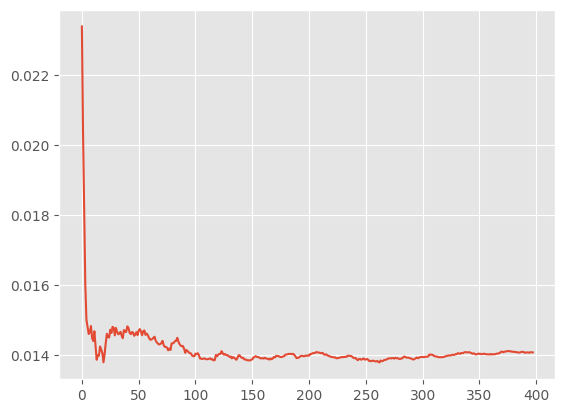

In [20]:
plt.plot(desviaciones)

Hacemos una gráfica un poco más elaborada

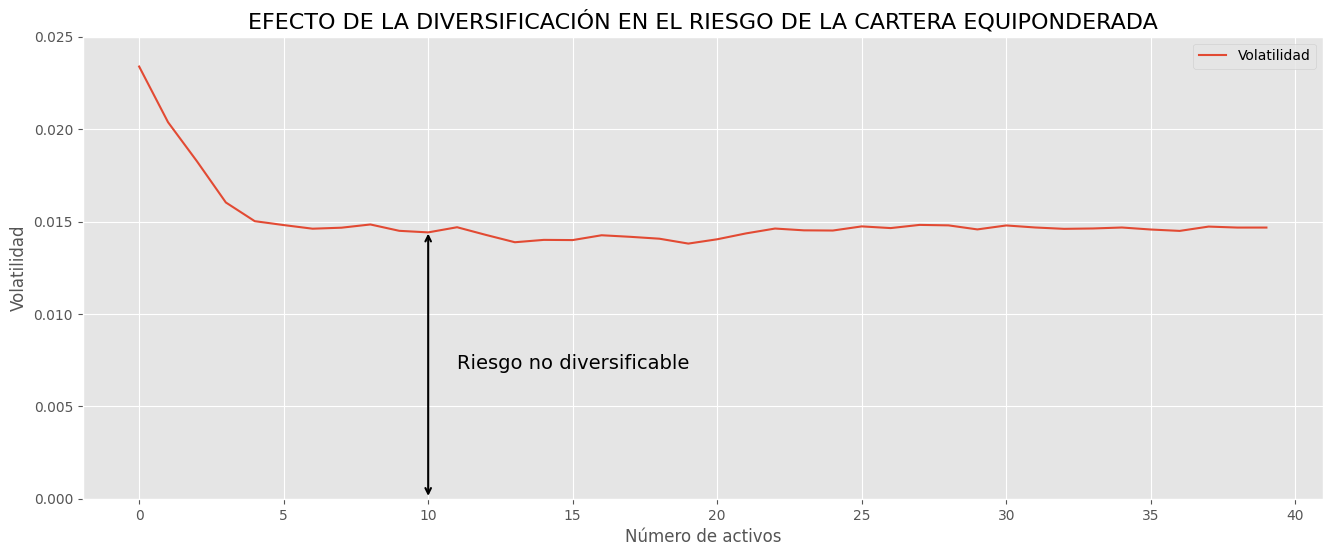

In [24]:
#hacemos la gráfica
plt.figure(figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
plt.plot(desviaciones[0:40], label='Volatilidad')
plt.xlabel('Número de activos')
plt.ylabel('Volatilidad')
plt.title('Volatilidad de la cartera equiponderada')
plt.legend()
plt.ylim(0, 0.025)

# Añadiendo la flecha bidireccional
# Añadiendo la flecha bidireccional con nuevas especificaciones
# Dibujando la flecha
#plt.arrow(10, 0, 0, 0.012, head_width=0.3, head_length=0.001, fc='black', ec='black')
plt.annotate('', xy=(10, 0), xytext=(10, 0.0145), 
             arrowprops=dict(arrowstyle="<->", lw=1.5, color='black'))
# Añadiendo el texto "Riesgo no diversificable" en la posición especificada
plt.text(11, 0.007, 'Riesgo no diversificable', fontsize=14, color='black')


plt.title('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA EQUIPONDERADA', fontsize=16)

plt.show()

## 3. Conclusión

1- Los efectos positivos de la diversificación tienen un límite, que es el riesgo sistemático, o el riesgo que no se puede eliminar. 

2- Hemos tomado conciencia de que el riesgo se divide en dos partes: una que puede ser diversificable (añadiendo más activos) y otra que no se puede eliminar (denominado riesgo sistemático). Por tanto, no tiene sentido exigir rentabilidad por el riesgo diversificable ya que se puede eliminar. Se retribuye el riesgo sistemático y, por tanto, necesitamos aprender a cuantificar dicho riesgo sistemático y relacionarlo con la rentabilidad exigida.

3- Con pocos activos llegamos al riesgo sistemático. Por tanto no necesitamos carteras con muchos activos.

#### CONTRIBUCIÓN DE UN ACTIVO AL RENDIMIENTO Y AL RIESGO DE UNA CARTERA

Contribución del activo $i$ al:

* **Rendimiento** de la cartera: $w_i E(\tilde R_i)$

* **Riesgo** de la cartera: $w_i^2cov(\tilde R_i, \tilde R_P)=w_i^2\sigma_{i,P}$

CONCLUSIONES:

* La aportación de un activo $i$ a la rentabilidad de la cartera depende del peso $w_i$ pero no depende de la composición de la cartera

* La aportación de un activo $i$ al riesgo de la cartera depende del peso $w_i$ y de la composición de la cartera, a algunas carteras les aportará más riesgo que a otras.

Por ejemplo, si un activo tiene una rentabilidad esperada positiva y una covarianza negativa con la cartera:

* **aumentará el rendimiento** de la cartera

* **disminuirá el riesgo** de la cartera.
